# Exercise Session: Logistic Regression
$\renewcommand{\real}{\mathbb{R}}$
$\renewcommand{\xb}{\mathbf{x}}$
$\renewcommand{\wb}{\mathbf{w}}$
$\renewcommand{\Xb}{\mathbf{X}}$
$\renewcommand{\yb}{\mathbf{y}}$
$\renewcommand{\Yb}{\mathbf{Y}}$
$\DeclareMathOperator*{\argmin}{argmin}$

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

# project files
import sys
sys.path.append('..')
import helpers as helpers

# 3rd party
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

# 1 Introduction

This week's exercise is about linear classification, in particular, logistic regression. We will focus on the binary classification scenario, i.e., two classes.

# 2 Binary Classification with Logistic Regression

Let's start by loading the [_Iris Flower Dataset_](https://en.wikipedia.org/wiki/Iris_flower_data_set). To facilitate visualization, we will only use 2 out of the 4 features of this dataset. Furthermore, we will use 2 out of the 3 classes in this dataset, named *setosa* and *versicolor*. Therefore, for this part our dataset with two classes is as follows:

  - data: $\Xb \in \real^{N \times 3}$, $\forall \xb_i \in \Xb: \xb_i \in \real^{3}$ (2 features and the bias)
  - labels: $\yb \in \real^{N}$, $\forall y_i \in \yb: y_i \in \{0, 1\}$ 

Note that $\Xb$ is a matrix of shape $(N \times (D+1))$. However, a single data sample $\xb_i$ is a column vector of shape $((D+1) \times 1)$. 
To compute a scalar product of one data sample with the weight vector $\wb$ (also a column vector of shape $((D+1) \times 1)$), we write $\xb_i^\top\cdot\wb$. To perform a matrix-vector multiplication of the entire data matrix with the weight vector, we write $\Xb\cdot\wb$.

<IPython.core.display.Javascript object>


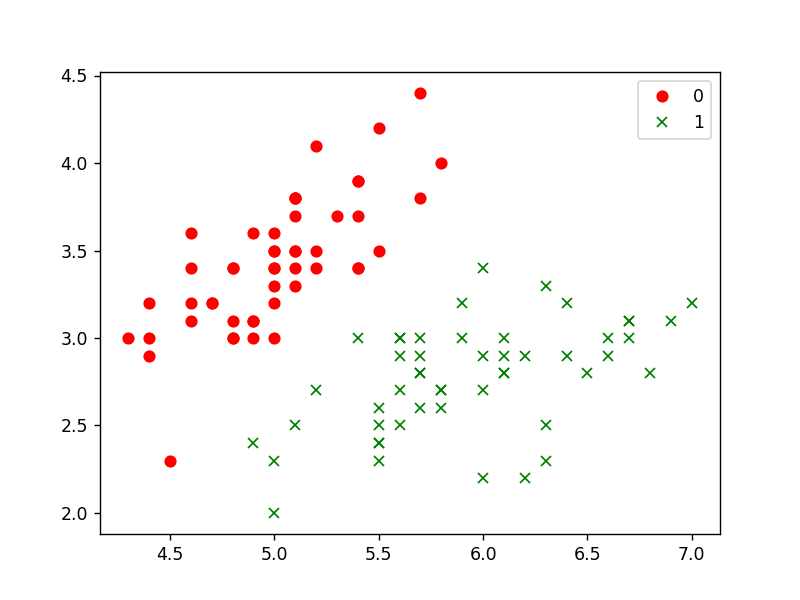

In [2]:
# Loads the data and split them into training and test subsets.
data, labels = helpers.load_ds_iris(sep_l=True, sep_w=True, pet_l=False, pet_w=False,
                              setosa=True, versicolor=True, virginica=False, addbias=True)
fig = helpers.scatter2d_multiclass(data, labels)

num_samples = data.shape[0]

fraction_train = 0.8
np.random.seed(0)
rinds = np.random.permutation(num_samples)

data_train = data[rinds[:int(num_samples * fraction_train)]] 
labels_train = labels[rinds[:int(num_samples * fraction_train)]]  

data_test = data[rinds[int(num_samples * fraction_train):]] 
labels_test = labels[rinds[int(num_samples * fraction_train):]]  

## 2.1 Short introduction

In logistic regression, the probability (score) that a data point belongs to the positive class is expressed as
$$P(y_i=1|\xb_i, \wb) = \frac{1}{1+e^{-\xb_i^{\top}\cdot \wb}} $$

This relies on the sigmoid function is defined as
$$\sigma(t)= \frac{1}{1+e^{-t}}$$

So in our case, the prediction of our model is defined as
$$\hat{y}(\xb_i)=\sigma(\xb_i^{\top}\cdot \wb)= \frac{1}{1+e^{-\xb_i^{\top}\cdot \wb}}$$

Let us code this function. You can use the numpy function `np.exp(x)` to take the exponential of a number.

In [3]:
def sigmoid(t):
    """ Sigmoid function
    
    Args:
        t (np.array): Input data of shape (N, )
        
    Returns:
        np.array: Probabilites of shape (N, ), where each value is in [0, 1].
    """
    return 1/(1 + np.exp(-t))

Recall that the cross entropy loss is defined as:
$$
R(\wb) = -\sum_i (y_i \log(\hat{y}(\xb_i)) + (1-y_i)\log(1-\hat{y}(\xb_i))) $$

Let's code it using NumPy. If you do it correctly, it can be written in one line!

In [13]:
def loss_logistic(data, labels, w): 
    """ Logistic regression loss function for binary classes
    
    Args:
        data (np.array): Dataset of shape (N, D).
        labels (np.array): Labels of shape (N, ).
        w (np.array): Weights of logistic regression model of shape (D, )
    Returns:
        int: Loss of logistic regression.
    """    
    return -np.sum(labels * np.log(sigmoid(data @ w)) + (1 - labels) * np.log(1 - sigmoid(data @ w)))

To move the weight vector towards the optimal weights, we need to compute the gradient of the loss function. This gradient is defined as
$$\nabla R(\wb)= \sum_i (\hat{y}(\xb_i) - y_i)\xb_i $$
Let us put this into a nice matrix format:
$$\nabla R(\wb)= \Xb^\top(\hat{y}(\Xb) - \yb) = \Xb^\top(\sigma(\Xb\cdot \wb) - \yb),
$$

where $\hat{y}(\Xb) = \sigma(\Xb\cdot \wb)$ and $\sigma(\Xb\cdot \wb)$ computes the sigmoid for each data sample separately, and returns a vector of shape $(N \times 1)$.

Fill in the function for computing the gradient `gradient_logistic()`. You can use the numpy function `np.dot()` or an operator `@` for matrix multiplication.

In [15]:
def gradient_logistic(data, labels, w):
    """ Logistic regression gradient function for binary classes
    
    Args:
        data (np.array): Dataset of shape (N, D).
        labels (np.array): Labels of shape (N, ).
        w (np.array): Weights of logistic regression model of shape (D, )
    Returns:
        np. array: Gradient array of shape (D, )
    """
    return data.T.dot(sigmoid(data.dot(w))-labels)
print(gradient_logistic(data_train, labels_train, np.linalg.pinv(data_train) @ labels_train))

[ 9.66207541 70.37848266 30.25209347]


## 2.2 Classification using a logistic regression model

Now let us write a function to perform classification using logistic regression, `logistic_regression_classify()`. This function uses the weights we find during training to predict the labels for the data.

**Hints:**
* We classify our data according to $P(y_i=1|\xb_i, \wb)$. If the value of $P(y_i=1|\xb_i, \wb)$ is less than 0.5 then the data point is classified as label 0. If it is more than or equal to 0.5 then we classify the data point as label 1.

In [20]:
def logistic_regression_classify(data, w):
    """ Classification function for binary class logistic regression. 
    
    Args:
        data (np.array): Dataset of shape (N, D).
        w (np.array): Weights of logistic regression model of shape (D, )
    Returns:
        np.array: Label assignments of data of shape (N, )
    """
    #### write your code here: find predictions and threshold.
    predictions = sigmoid(data@w)
    predictions[predictions<0.5]=0
    predictions[predictions>=0.5]=1        
    return predictions
print(logistic_regression_classify(data_test, np.linalg.pinv(data_train) @ labels_train))
print(labels_test)

[1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
[1 1 0 1 1 0 0 1 0 0 0 1 1 0 1 0 0 0 1 1]


We measure the performance of our classifier with *accuracy* metric. It is defined as $$ f_{\text{acc}} = \frac{\text{# correct predictions}}{\text{# all predictions}}$$
Implement the following `accuracy()` function using the predicted and ground truth labels.

In [23]:
def accuracy(labels_gt, labels_pred):
    """ Computes accuracy.
    
    Args:
        labels_gt (np.array): GT labels of shape (N, ).
        labels_pred (np.array): Predicted labels of shape (N, ).
        
    Returns:
        float: Accuracy, in range [0, 1].
    """
    np.sum(np.abs(labels_gt - labels_pred)==0)
    
    return np.sum(labels_gt == labels_pred) / labels_gt.shape[0]

## 2.3 Training a logistic regression model

To find the optimal weights for the given training data, we need to train our model. Fill in the missing parts of the function `logistic_regression_train()`.

The function first initializes the weights randomly (according to a Gaussian distribution). In each iteration, you should compute the gradient using `gradient_logistic` and take a gradient step to update the weights. Given that $\eta$ is the learning rate, recall that a gradient step is expressed as: $$ \wb_{[t + 1]}  = \wb_{[t]} - \eta \nabla R(\wb_{[t]}) $$

The `loss`, `plot` and `print_every` parameters affect the way the loss is printed and the predictions are displayed. You do not need to modify these parts.



In [24]:
def logistic_regression_train(data, labels, max_iters=10, lr=0.001, 
                              print_period=1000, plot_period=1000):
    """ Training function for binary class logistic regression. 
    
    Args:
        data (np.array): Dataset of shape (N, D).
        labels (np.array): Labels of shape (N, ).
        max_iters (integer): Maximum number of iterations. Default:10
        lr (integer): The learning rate of  the gradient step. Default:0.001
        print_period (int): Num. iterations to print current loss. 
            If 0, never printed.
        plot_period (int): Num. iterations to plot current predictions.
            If 0, never plotted.
    Returns:
        np.array: weights of shape(D, )
    """

    #initialize the weights randomly according to a Gaussian distribution
    weights = np.random.normal(0., 0.1, [data.shape[1],])
    for it in range(max_iters):
        ########## write your code here: find gradient and do a gradient step
        gradient = gradient_logistic(data, labels, weights)
        weights = weights - lr*gradient
        ##################################
        predictions = logistic_regression_classify(data, weights)
        if print_period and it % print_period == 0:
            print('loss at iteration', it, ":", loss_logistic(data, labels, weights))
        if plot_period and it % plot_period == 0:
            fig = helpers.visualize_predictions(data=data, labels_gt=labels, labels_pred=predictions)
            plt.title("iteration "+ str(it))
        if accuracy(labels, predictions) == 1:
            break
    fig = helpers.visualize_predictions(data=data, labels_gt=labels, labels_pred=predictions)
    plt.title("iteration "+ str(it))
    return weights

Run the code below to see your training in action. What do you observe? Try playing with the learning rate and number of max iterations.

loss at iteration 0 : 99.93029111226083


<IPython.core.display.Javascript object>


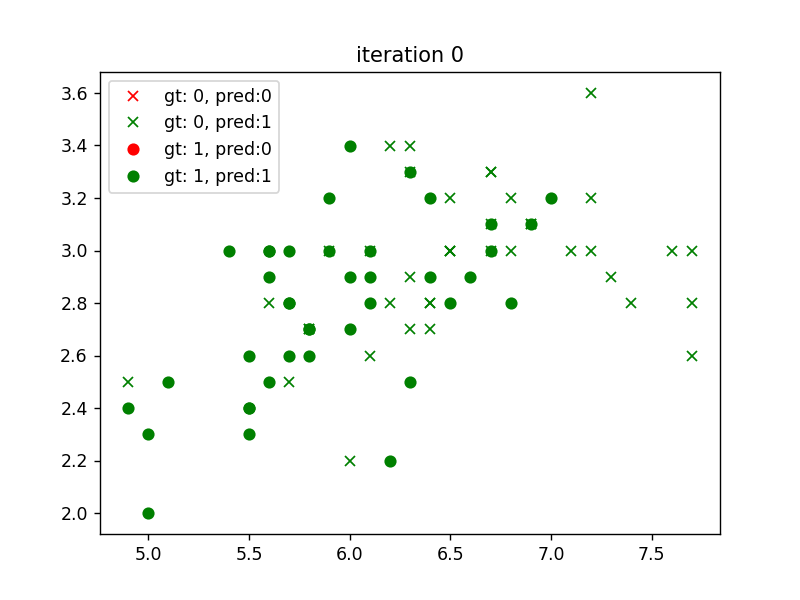

loss at iteration 1000 : 285.5221680068818
loss at iteration 2000 : 248.55592729871995
loss at iteration 3000 : 225.77598680200043


<IPython.core.display.Javascript object>


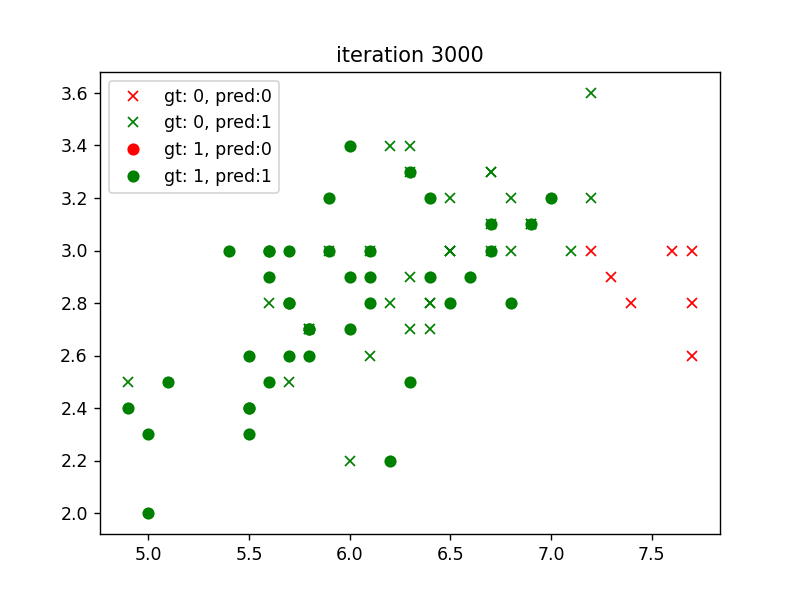

loss at iteration 4000 : 209.03275894984966
loss at iteration 5000 : 197.84967507544644
loss at iteration 6000 : 186.93469953074535


<IPython.core.display.Javascript object>


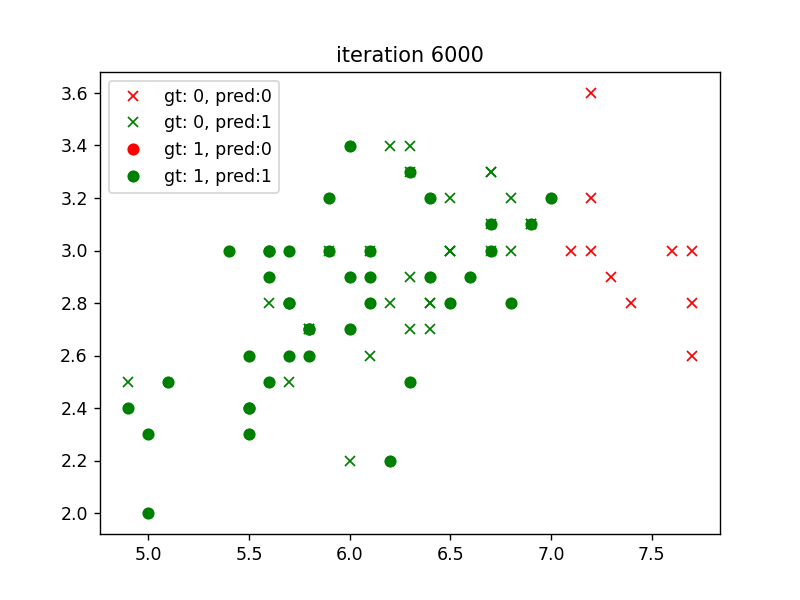

loss at iteration 7000 : 178.08421150144082
loss at iteration 8000 : 173.03385125346676
loss at iteration 9000 : 170.18579398672642


<IPython.core.display.Javascript object>


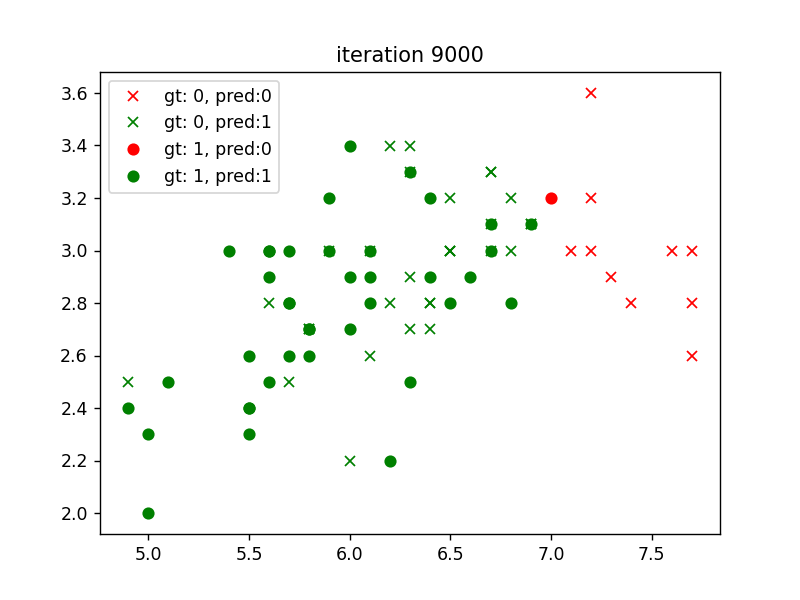

loss at iteration 10000 : 168.50406920633563
loss at iteration 11000 : 167.48869870579443
loss at iteration 12000 : 166.8705371997014


<IPython.core.display.Javascript object>


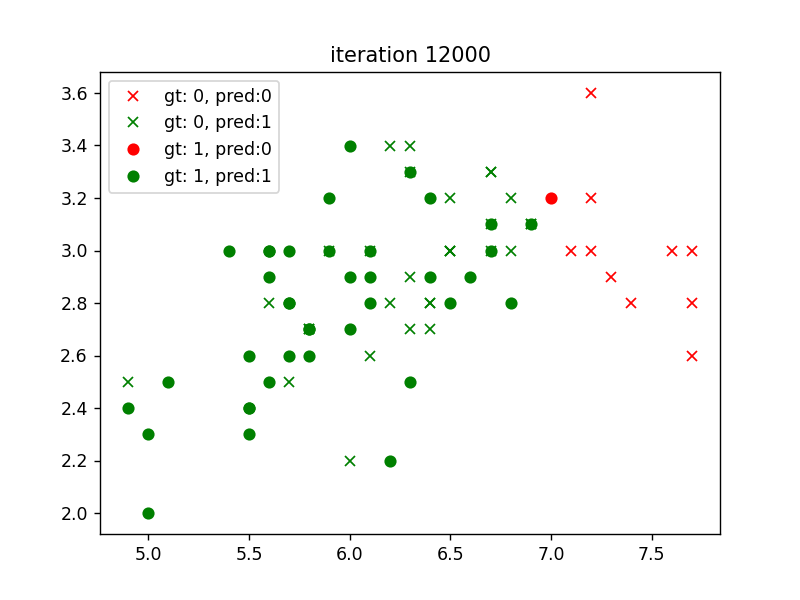

loss at iteration 13000 : 166.49313114669246
loss at iteration 14000 : 166.26252166718368
loss at iteration 15000 : 166.12158874085435


<IPython.core.display.Javascript object>


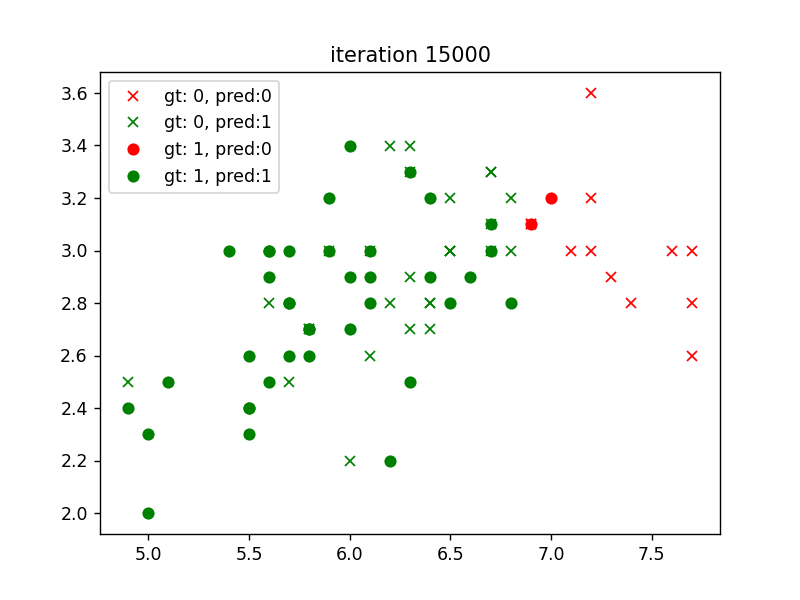

loss at iteration 16000 : 166.03546380990042
loss at iteration 17000 : 165.98283651993887
loss at iteration 18000 : 165.95068042895804


<IPython.core.display.Javascript object>


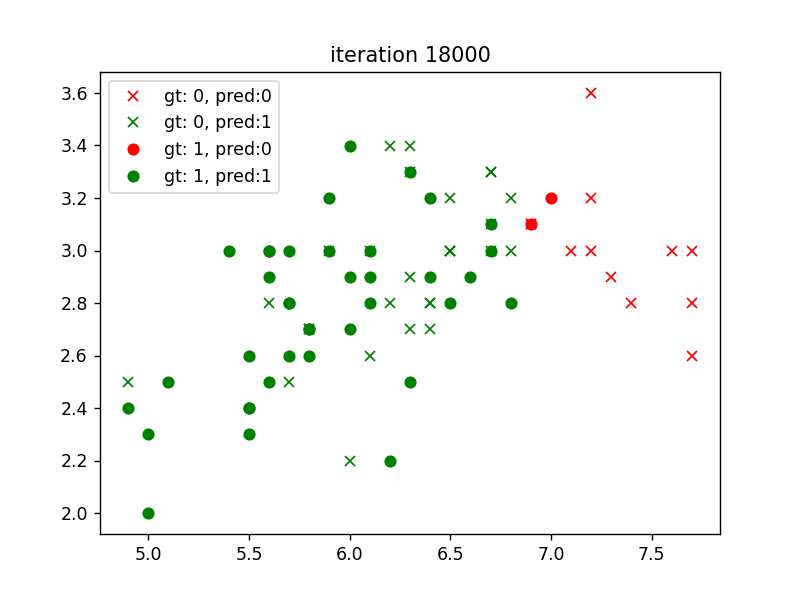

loss at iteration 19000 : 165.93103351272111
loss at iteration 20000 : 165.9190299263522
loss at iteration 21000 : 165.91169631298584


<IPython.core.display.Javascript object>


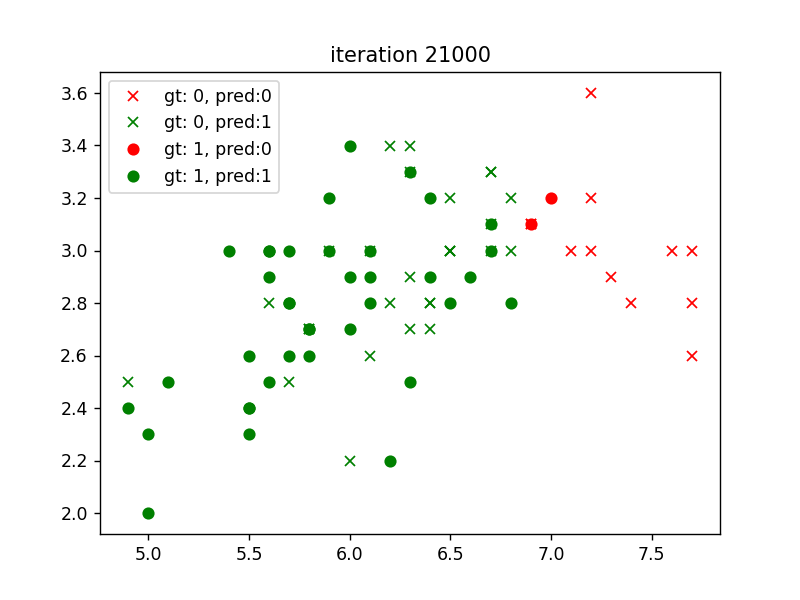

loss at iteration 22000 : 165.90721588140076
loss at iteration 23000 : 165.90447860184577
loss at iteration 24000 : 165.90280630722648


<IPython.core.display.Javascript object>


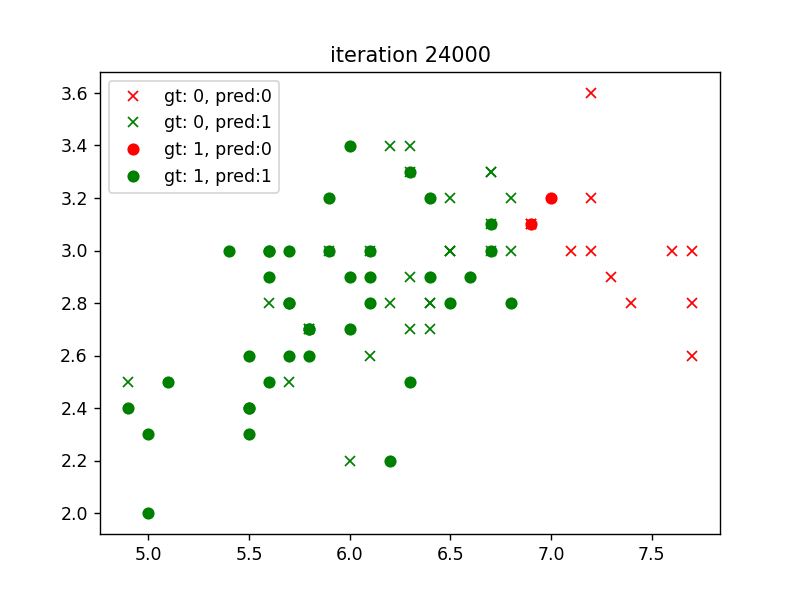

loss at iteration 25000 : 165.90178463959597
loss at iteration 26000 : 165.90116047775695
loss at iteration 27000 : 165.90077915385365


<IPython.core.display.Javascript object>


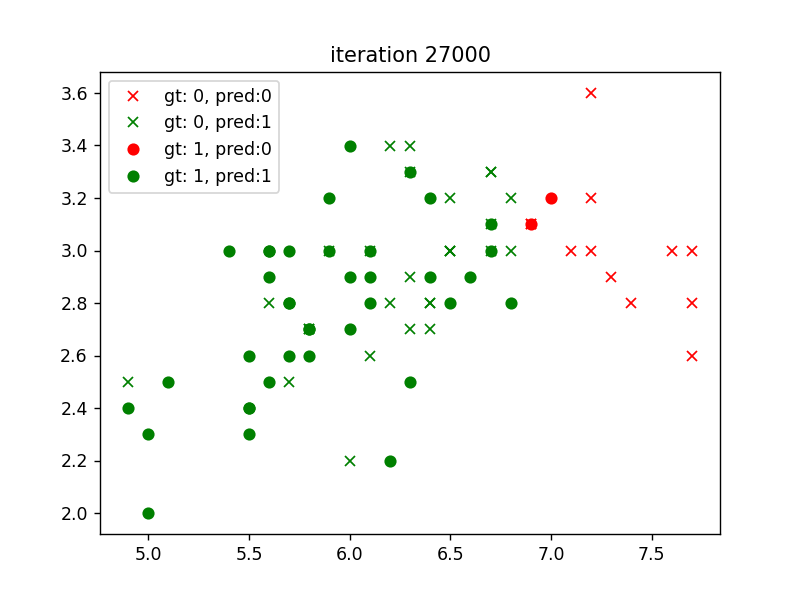

loss at iteration 28000 : 165.9005461872166
loss at iteration 29000 : 165.9004038647695
loss at iteration 30000 : 165.90031691402714


<IPython.core.display.Javascript object>


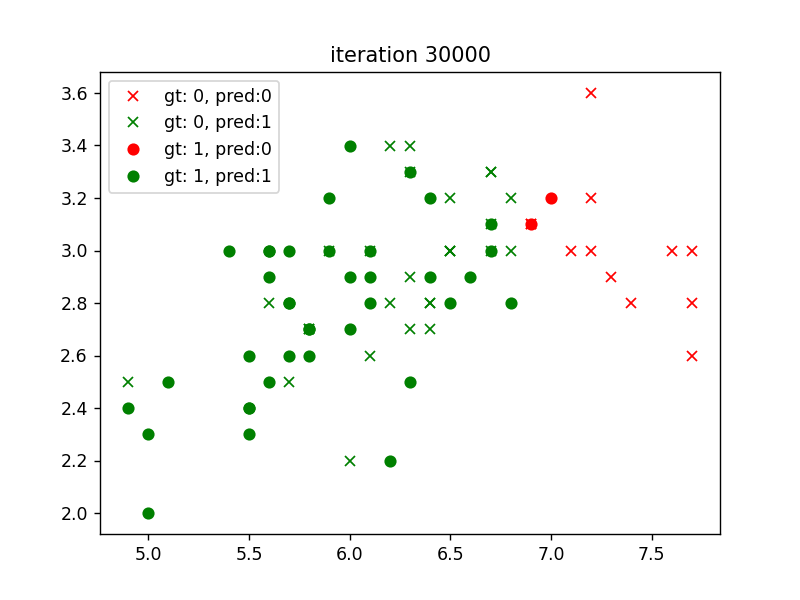

loss at iteration 31000 : 165.90026378909545
loss at iteration 32000 : 165.90023134043864
loss at iteration 33000 : 165.90021151004916


<IPython.core.display.Javascript object>


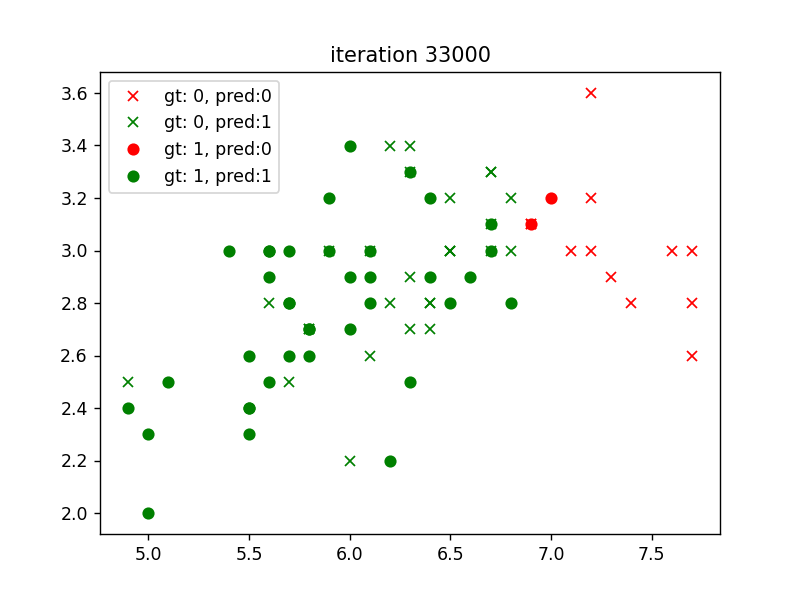

loss at iteration 34000 : 165.9001994014552
loss at iteration 35000 : 165.9001920026428
loss at iteration 36000 : 165.9001874715051


<IPython.core.display.Javascript object>


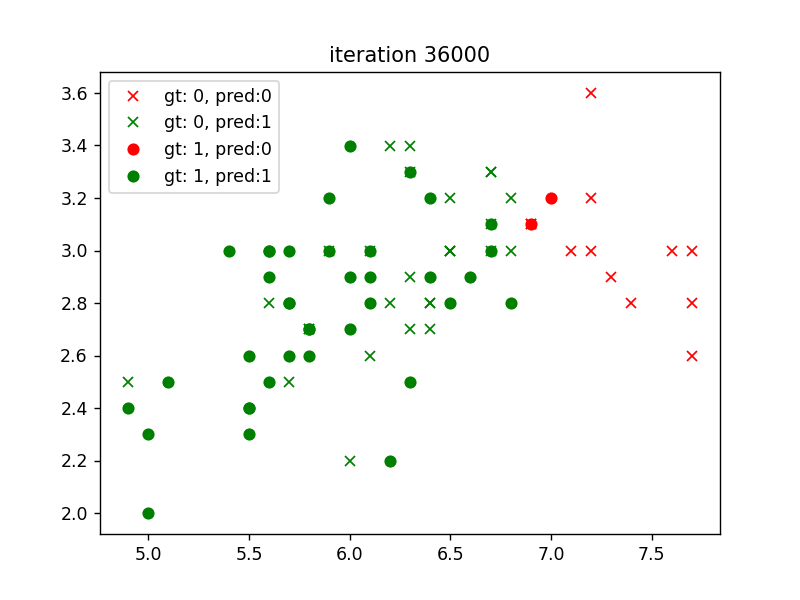

loss at iteration 37000 : 165.9001847200589
loss at iteration 38000 : 165.9001830229651
loss at iteration 39000 : 165.9001820003527


<IPython.core.display.Javascript object>


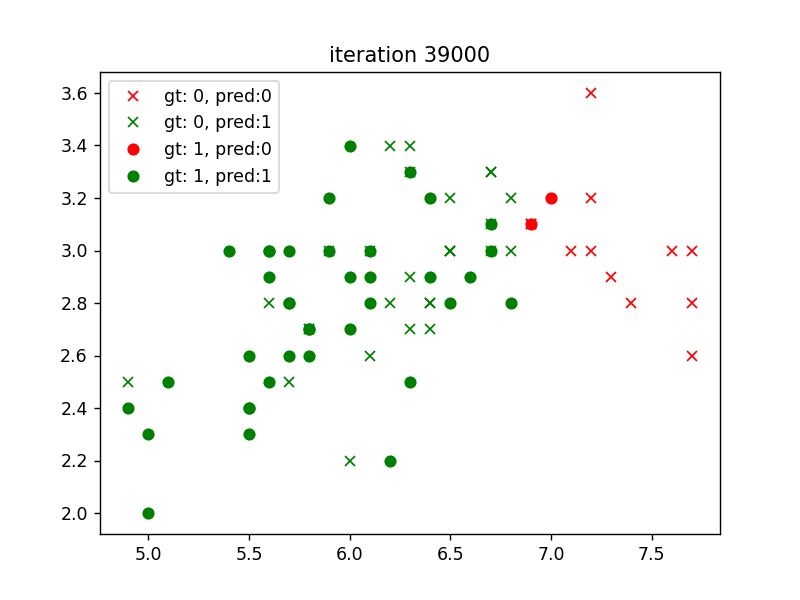

loss at iteration 40000 : 165.90018136400954
loss at iteration 41000 : 165.9001809823311
loss at iteration 42000 : 165.90018074915412


/mnt/c/Users/abehs/OneDrive/@Academics/btrois_epfl/cs233. IntroML/Week 4/exercise/helpers.py:183: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, _ = plt.subplots(1, 1)


<IPython.core.display.Javascript object>


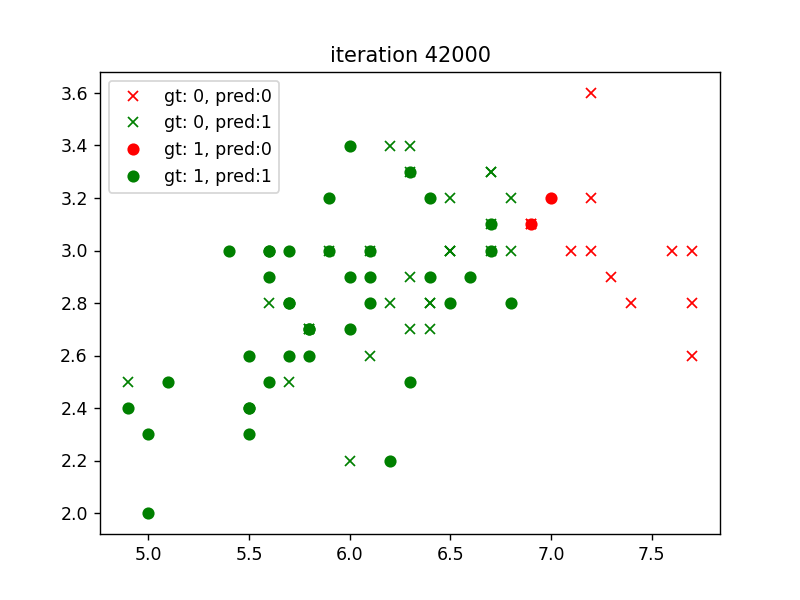

loss at iteration 43000 : 165.90018060669735
loss at iteration 44000 : 165.9001805196695
loss at iteration 45000 : 165.90018046649323


<IPython.core.display.Javascript object>


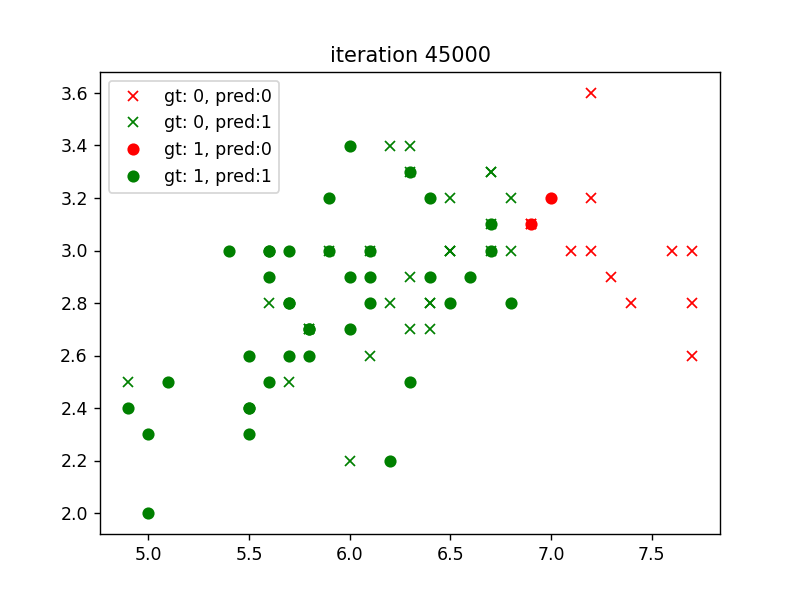

loss at iteration 46000 : 165.9001804340058
loss at iteration 47000 : 165.90018041416363
loss at iteration 48000 : 165.9001804020356


<IPython.core.display.Javascript object>


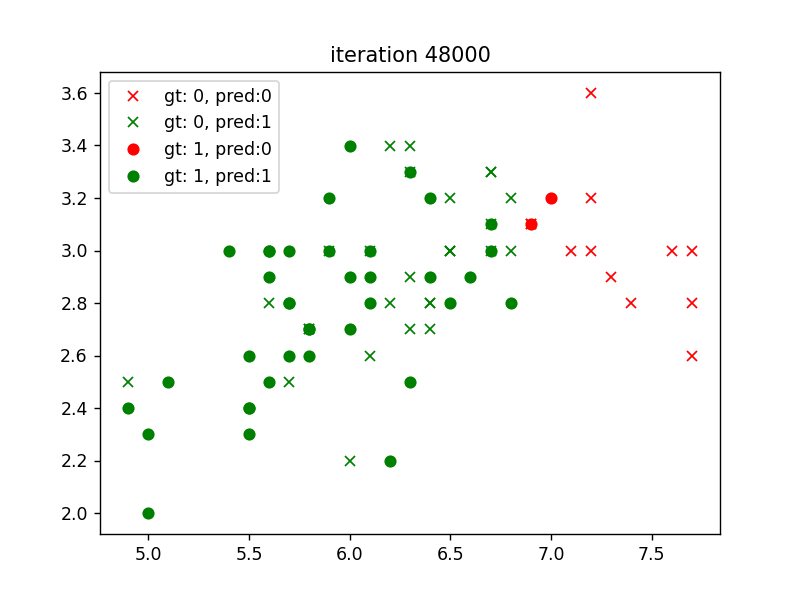

loss at iteration 49000 : 165.90018039463178
loss at iteration 50000 : 165.9001803901092
loss at iteration 51000 : 165.90018038735184


<IPython.core.display.Javascript object>


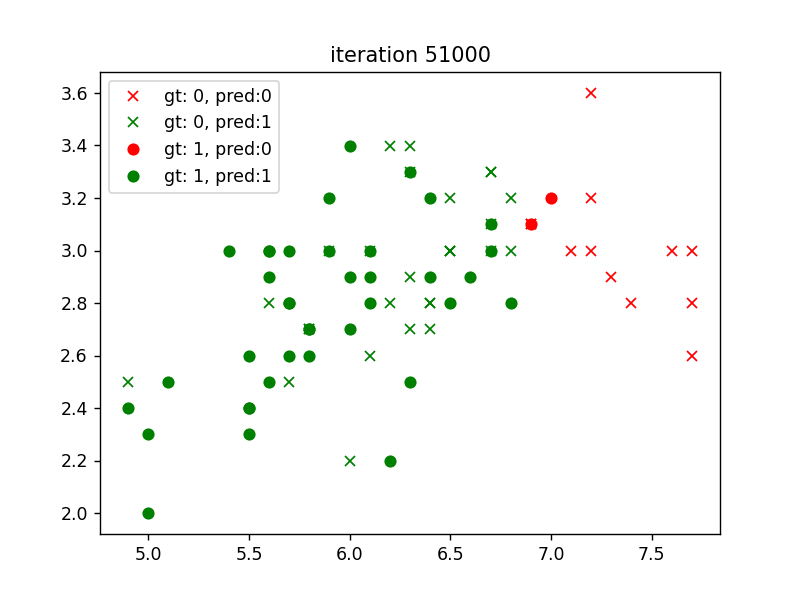

loss at iteration 52000 : 165.9001803856641
loss at iteration 53000 : 165.90018038462824
loss at iteration 54000 : 165.90018038400285


<IPython.core.display.Javascript object>


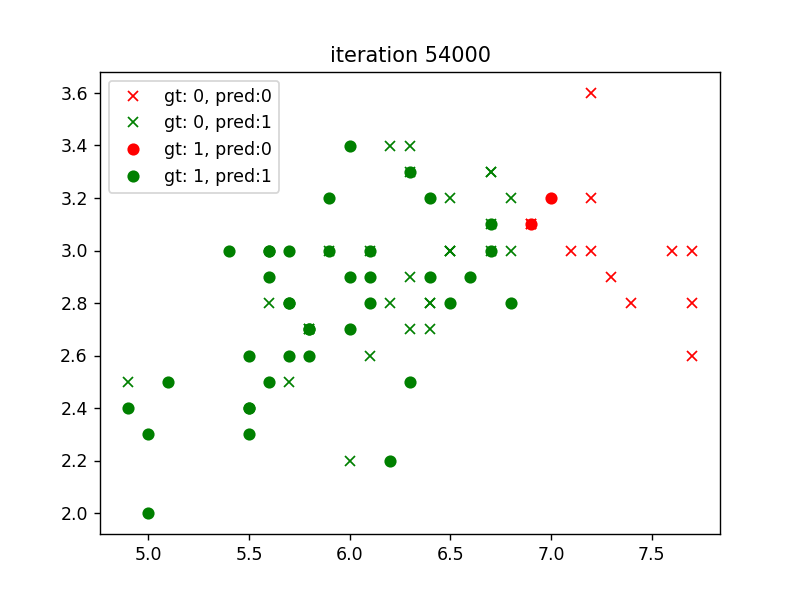

loss at iteration 55000 : 165.9001803836046
loss at iteration 56000 : 165.90018038336834
loss at iteration 57000 : 165.90018038322177


<IPython.core.display.Javascript object>


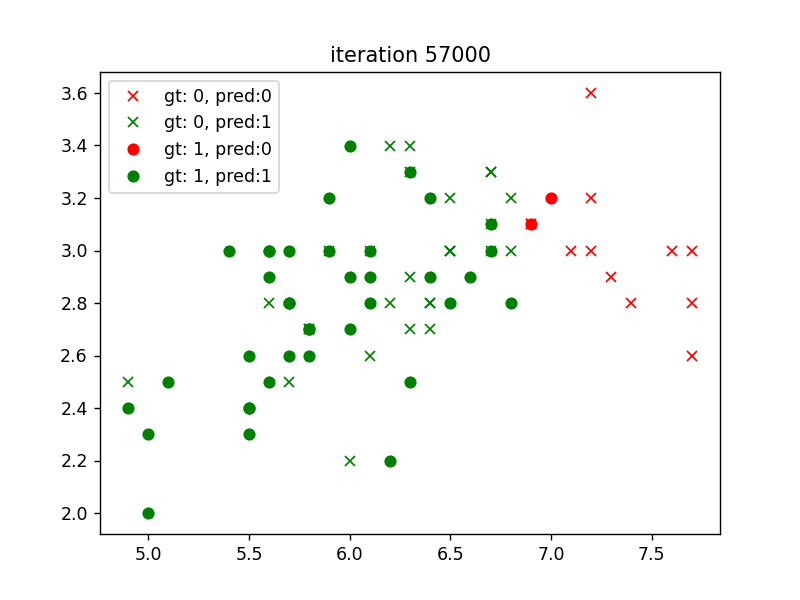

loss at iteration 58000 : 165.9001803831373
loss at iteration 59000 : 165.90018038309776
loss at iteration 60000 : 165.9001803830663


<IPython.core.display.Javascript object>


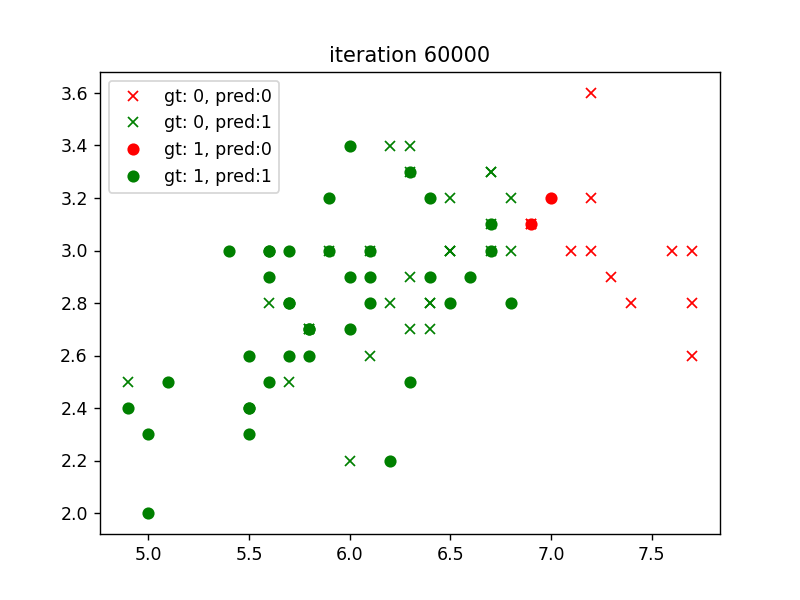

loss at iteration 61000 : 165.90018038305067
loss at iteration 62000 : 165.9001803830375
loss at iteration 63000 : 165.90018038303236


<IPython.core.display.Javascript object>


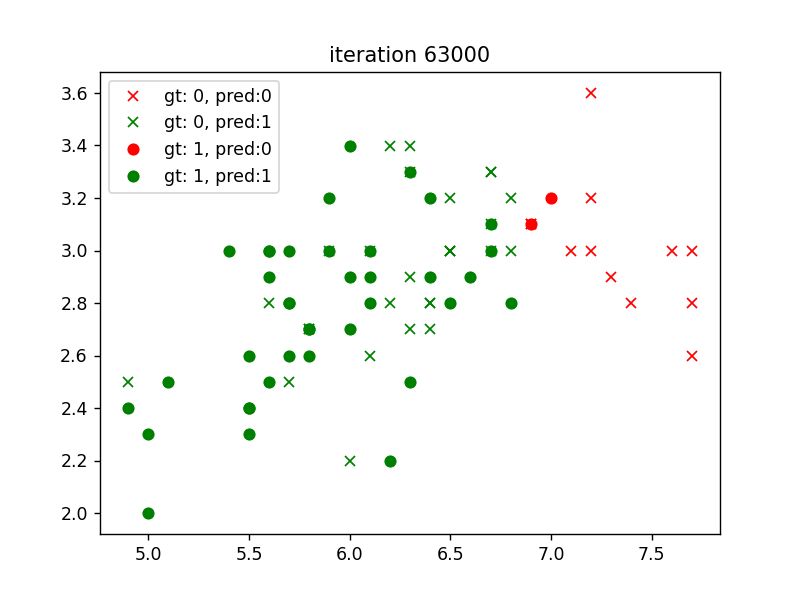

loss at iteration 64000 : 165.90018038303168
loss at iteration 65000 : 165.90018038303168
loss at iteration 66000 : 165.90018038303168


<IPython.core.display.Javascript object>


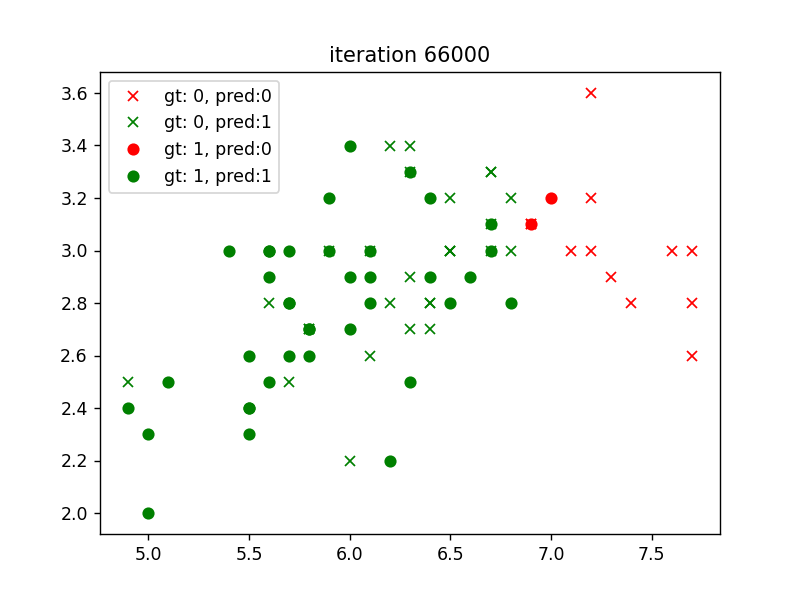

loss at iteration 67000 : 165.90018038303168
loss at iteration 68000 : 165.90018038303168
loss at iteration 69000 : 165.90018038303168


<IPython.core.display.Javascript object>


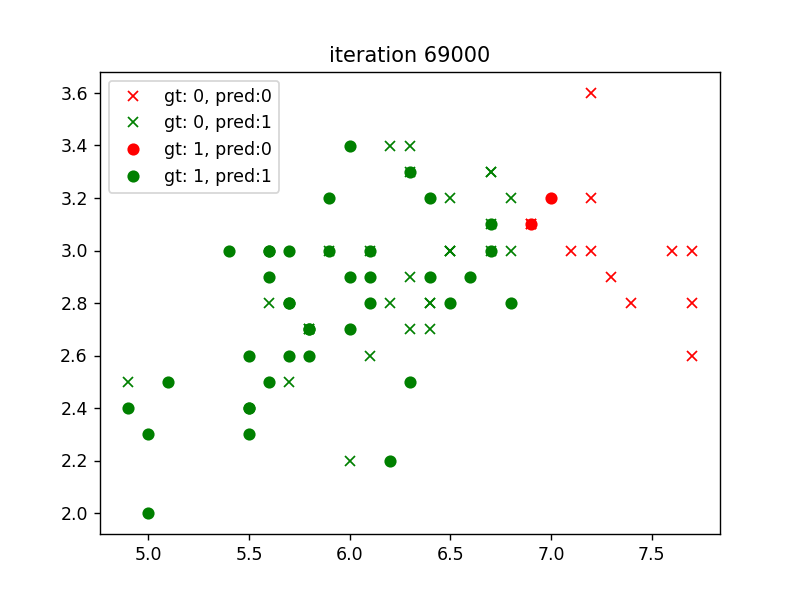

loss at iteration 70000 : 165.90018038303168
loss at iteration 71000 : 165.90018038303168
loss at iteration 72000 : 165.90018038303168


<IPython.core.display.Javascript object>


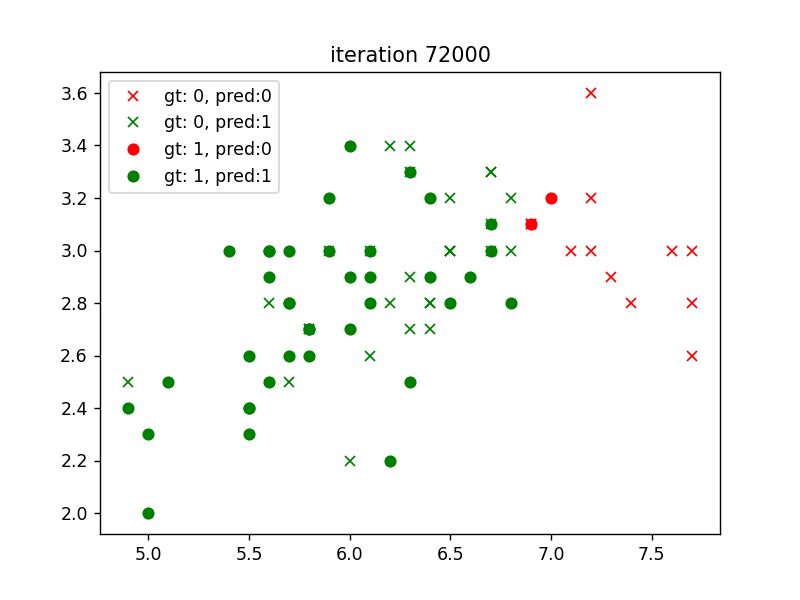

loss at iteration 73000 : 165.90018038303168
loss at iteration 74000 : 165.90018038303168
loss at iteration 75000 : 165.90018038303168


<IPython.core.display.Javascript object>


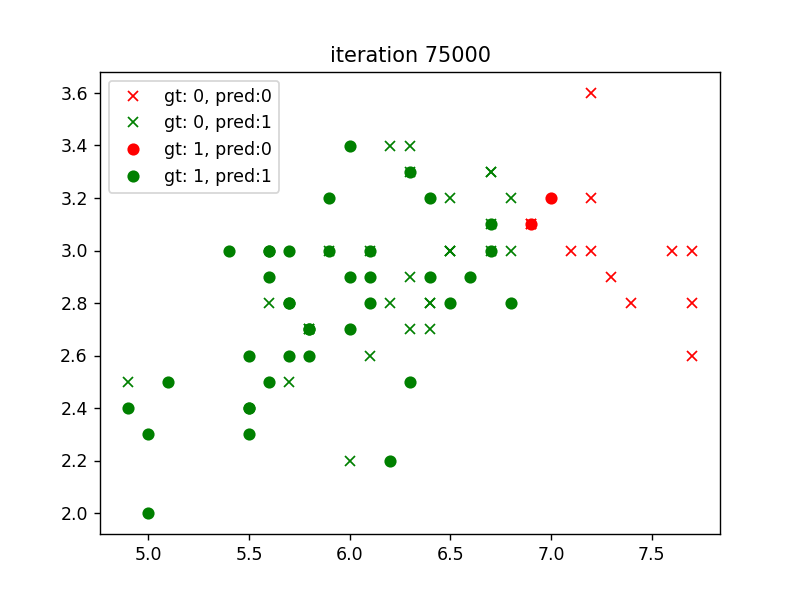

loss at iteration 76000 : 165.90018038303168
loss at iteration 77000 : 165.90018038303168
loss at iteration 78000 : 165.90018038303168


<IPython.core.display.Javascript object>


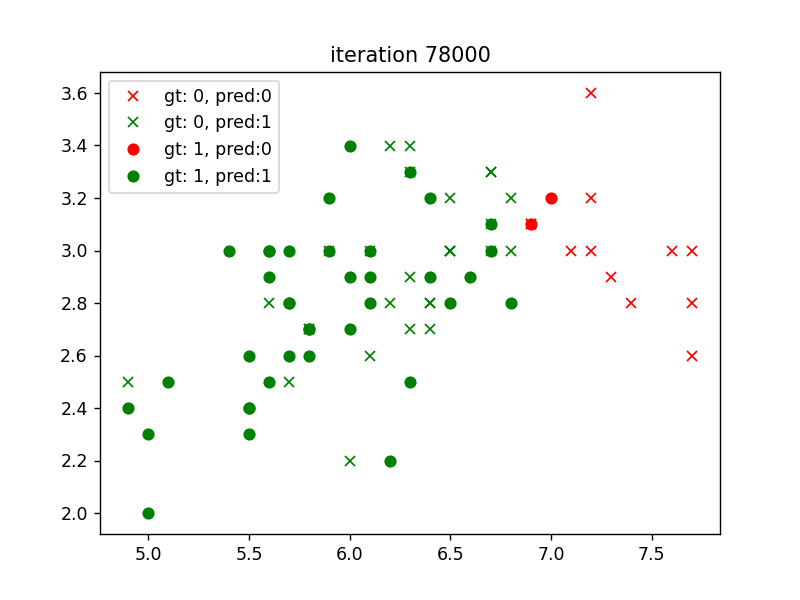

loss at iteration 79000 : 165.90018038303168
loss at iteration 80000 : 165.90018038303168
loss at iteration 81000 : 165.90018038303168


<IPython.core.display.Javascript object>


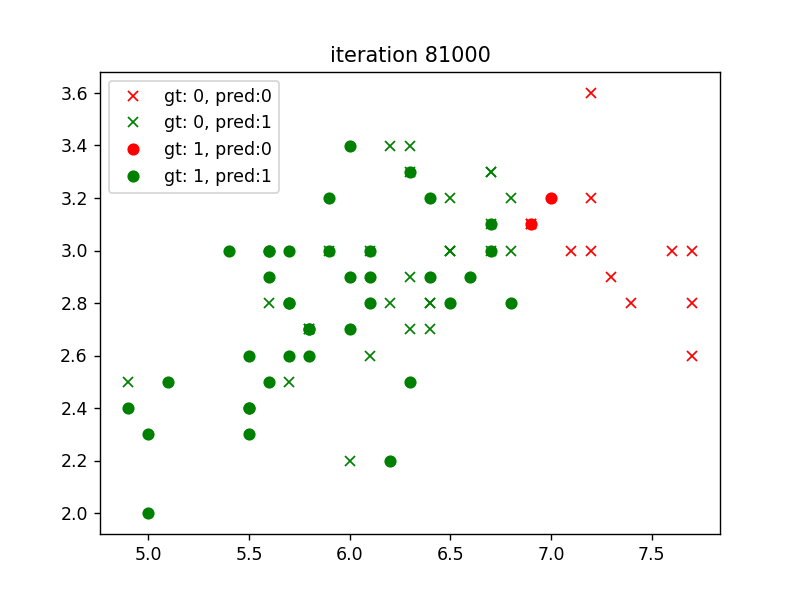

loss at iteration 82000 : 165.90018038303168
loss at iteration 83000 : 165.90018038303168
loss at iteration 84000 : 165.90018038303168


<IPython.core.display.Javascript object>


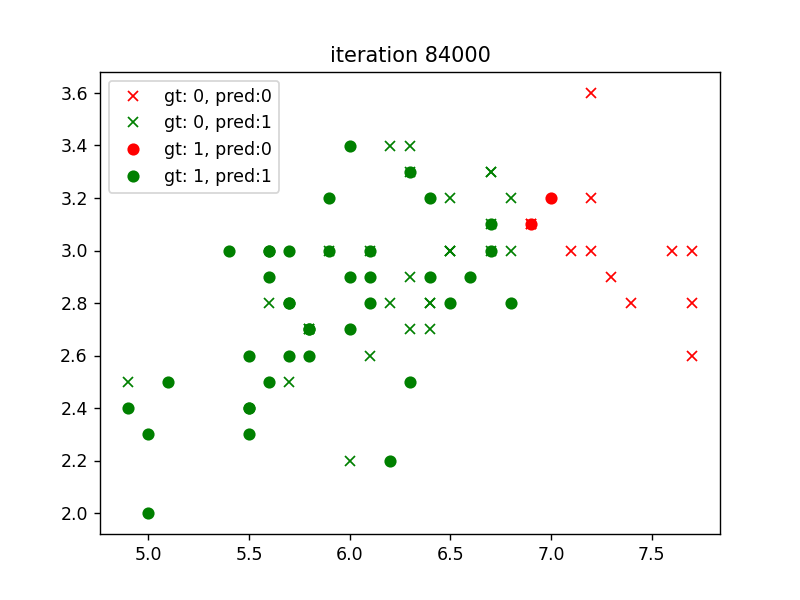

loss at iteration 85000 : 165.90018038303168
loss at iteration 86000 : 165.90018038303168
loss at iteration 87000 : 165.90018038303168


<IPython.core.display.Javascript object>


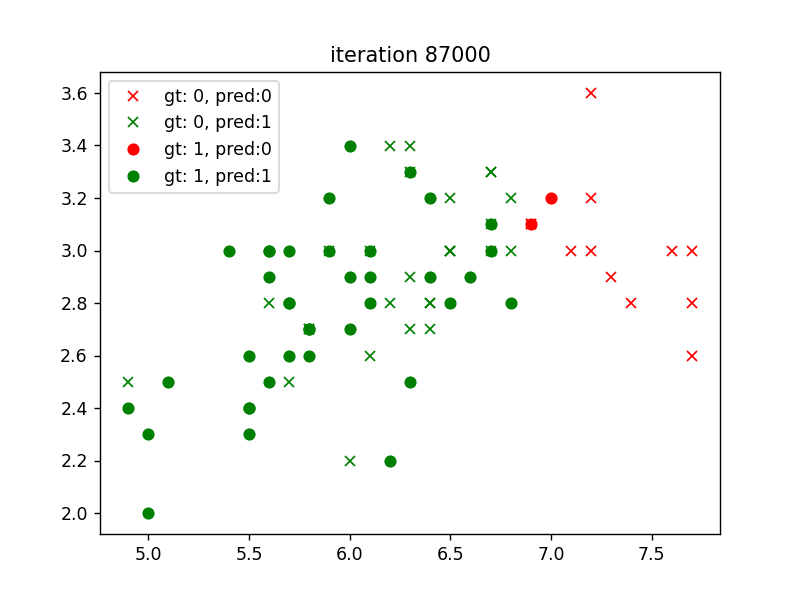

loss at iteration 88000 : 165.90018038303168
loss at iteration 89000 : 165.90018038303168
loss at iteration 90000 : 165.90018038303168


<IPython.core.display.Javascript object>


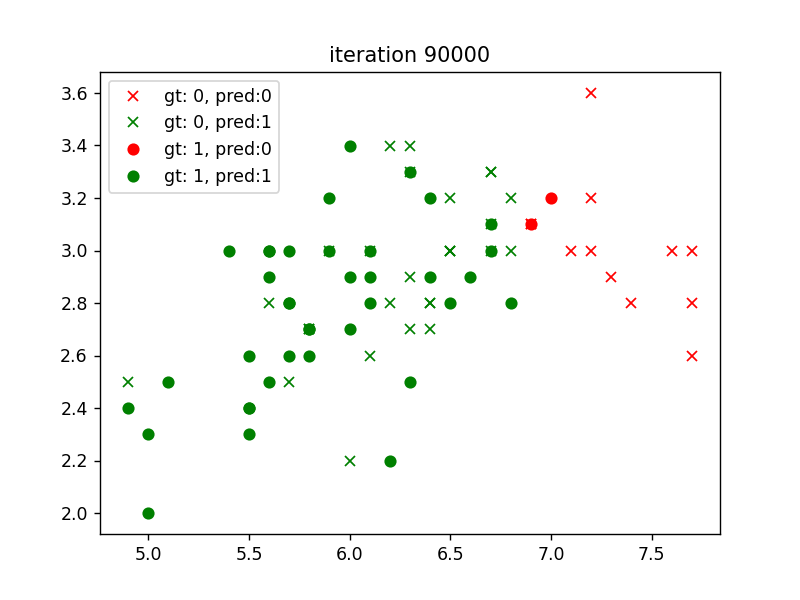

loss at iteration 91000 : 165.90018038303168
loss at iteration 92000 : 165.90018038303168
loss at iteration 93000 : 165.90018038303168


<IPython.core.display.Javascript object>


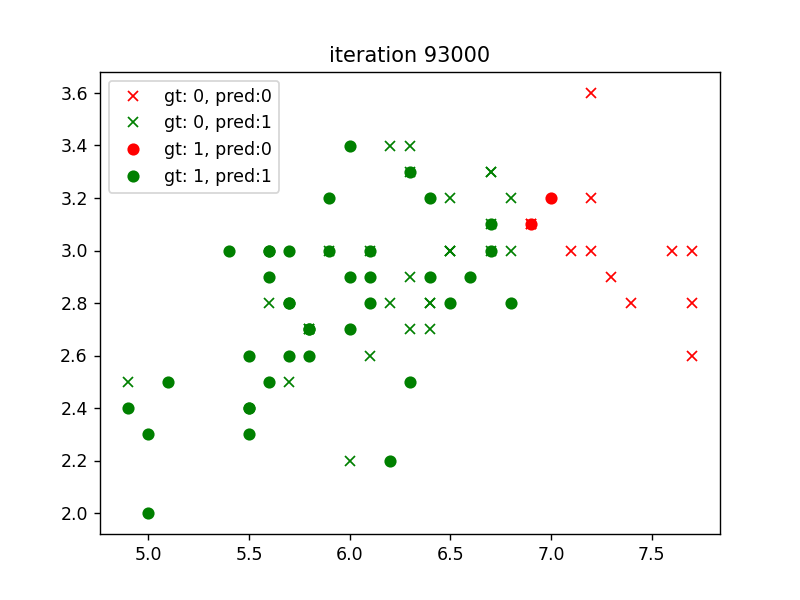

loss at iteration 94000 : 165.90018038303168
loss at iteration 95000 : 165.90018038303168
loss at iteration 96000 : 165.90018038303168


<IPython.core.display.Javascript object>


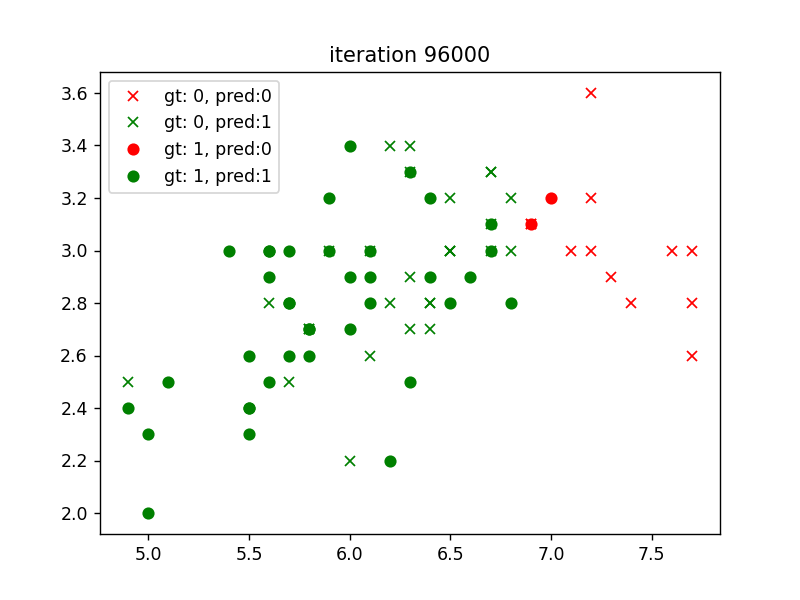

loss at iteration 97000 : 165.90018038303168
loss at iteration 98000 : 165.90018038303168
loss at iteration 99000 : 165.90018038303168


<IPython.core.display.Javascript object>


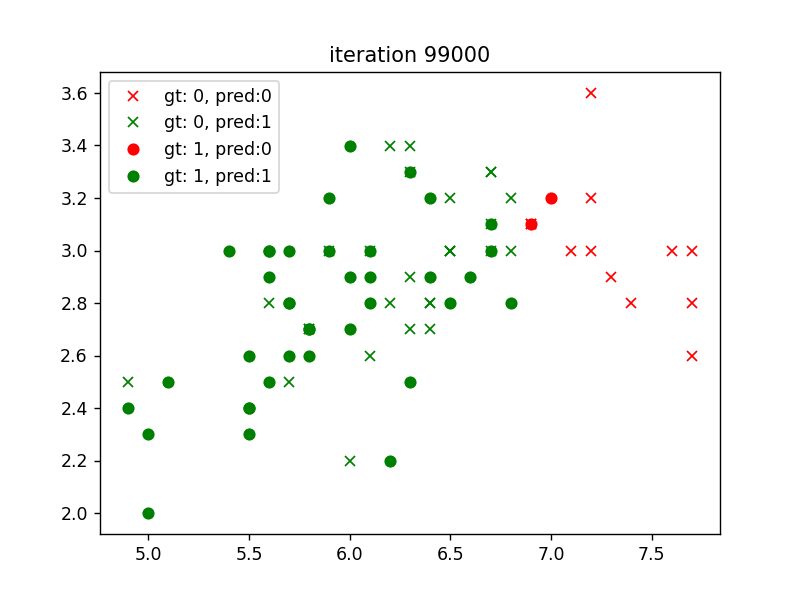

<IPython.core.display.Javascript object>


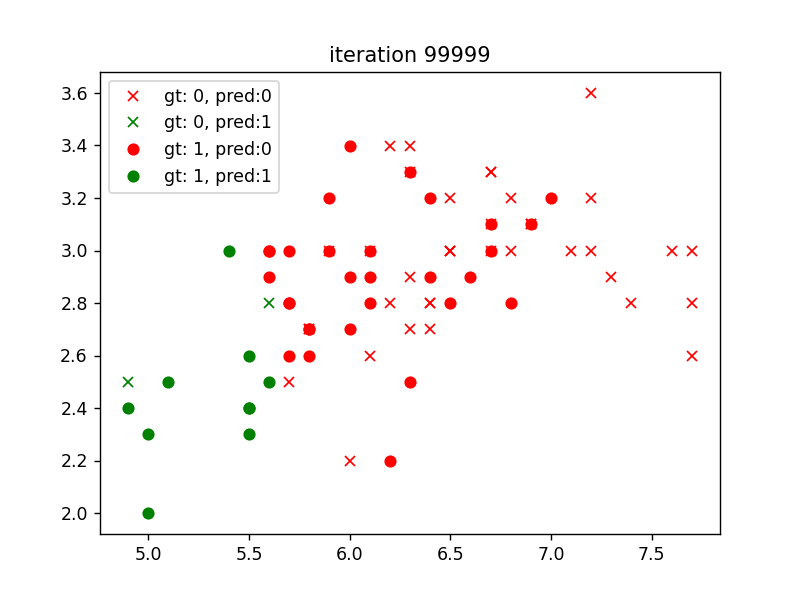

In [25]:
weights = logistic_regression_train(data_train, labels_train, max_iters=100000, lr=1e-2, print_period=1000, plot_period=3000)

<IPython.core.display.Javascript object>


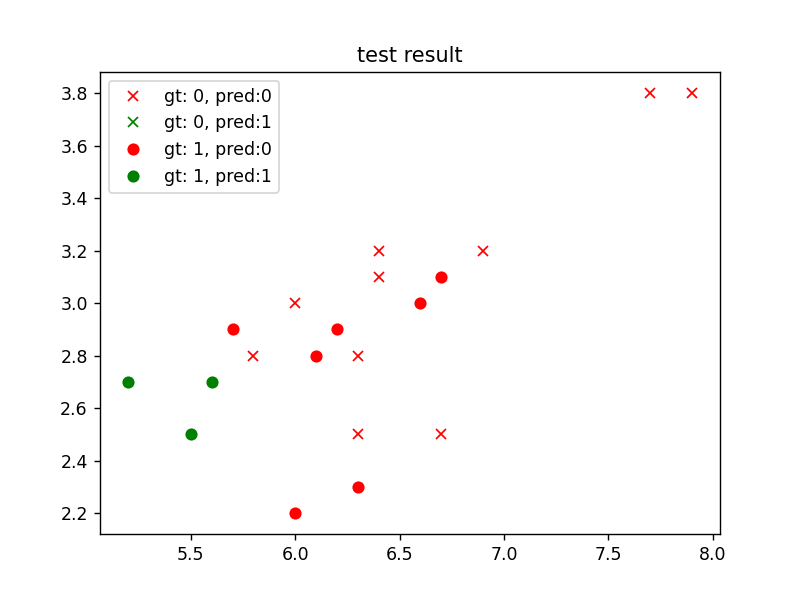

Accuracy is 0.65


In [27]:
predictions = logistic_regression_classify(data_test, weights)
fig = helpers.visualize_predictions(data=data_test, labels_gt=labels_test, labels_pred=predictions)
plt.title("test result")
print("Accuracy is", accuracy(labels_test, predictions))

# 3 Different Data

Let us now use the same dataset, with the same 2 features as before, but change the 2 classes to *versicolor* and *virginica*. As we use the features and the same number of classes, our dataset as the same form as before:

  - data: $\Xb \in \real^{N \times 3}$, $\forall \xb_i \in \Xb: \xb_i \in \real^{3}$ (2 features and the bias)
  - labels: $\yb \in \real^{N}$, $\forall y_i \in \yb: y_i \in \{0, 1\}$ 


<IPython.core.display.Javascript object>


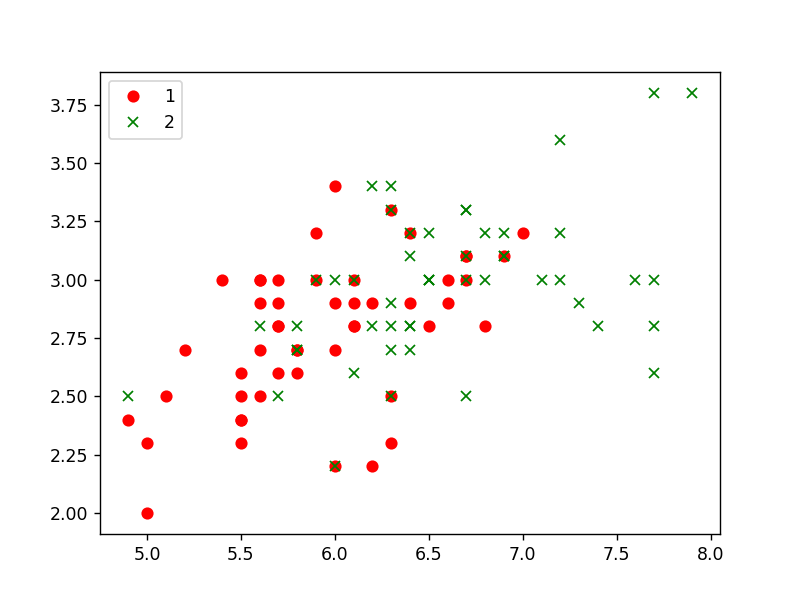

In [11]:
# Loads the data and split them into trian and test subsets.
data, labels = helpers.load_ds_iris(sep_l=True, sep_w=True, pet_l=False, pet_w=False,
                              setosa=False, versicolor=True, virginica=True, addbias=True)
fig = helpers.scatter2d_multiclass(data, labels)

num_samples = data.shape[0]

fraction_train = 0.8
np.random.seed(0)
rinds = np.random.permutation(num_samples)

data_train = data[rinds[:int(num_samples * fraction_train)]] 
labels_train = labels[rinds[:int(num_samples * fraction_train)]]  
labels_train[labels_train==2] = 0

data_test = data[rinds[int(num_samples * fraction_train):]] 
labels_test = labels[rinds[int(num_samples * fraction_train):]]  
labels_test[labels_test==2] = 0




Now you can perform training and evaluation on this dataset. We leave this part to you. 
Note: We recommend reducing the plotting period of the `logistic_regression_train` function.

loss at iteration 0 : 54.98251182450983


<IPython.core.display.Javascript object>


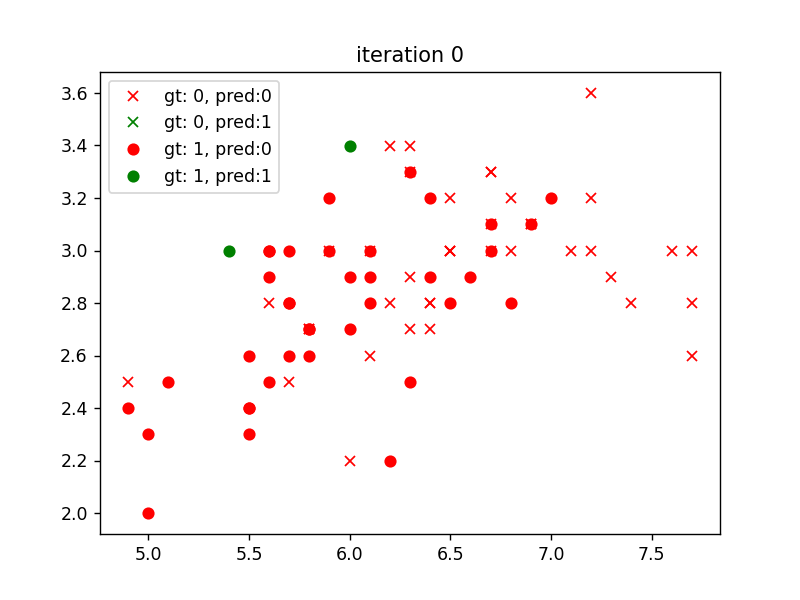

loss at iteration 100 : 54.22987714840397
loss at iteration 200 : 53.623597535125896
loss at iteration 300 : 53.122227662677375
loss at iteration 400 : 52.69904085823519
loss at iteration 500 : 52.33468550529863
loss at iteration 600 : 52.01512293039112
loss at iteration 700 : 51.73012257772355
loss at iteration 800 : 51.47218348901235
loss at iteration 900 : 51.23576717948411
loss at iteration 1000 : 51.01675279950362
loss at iteration 1100 : 50.8120493337679
loss at iteration 1200 : 50.61931840125278
loss at iteration 1300 : 50.4367750461609
loss at iteration 1400 : 50.263043731622254
loss at iteration 1500 : 50.09705360949461
loss at iteration 1600 : 49.937961900609594
loss at iteration 1700 : 49.78509751948093
loss at iteration 1800 : 49.63791936960068
loss at iteration 1900 : 49.49598533461712
loss at iteration 2000 : 49.35892911265442
loss at iteration 2100 : 49.226442833146564
loss at iteration 2200 : 49.09826395847769
loss at iteration 2300 : 48.97416537542777
loss at iteration

loss at iteration 19000 : 44.499577988974174
loss at iteration 19100 : 44.49719702262206
loss at iteration 19200 : 44.494862368626784
loss at iteration 19300 : 44.492573075559335
loss at iteration 19400 : 44.49032821297949
loss at iteration 19500 : 44.488126870931126
loss at iteration 19600 : 44.48596815945077
loss at iteration 19700 : 44.48385120808922
loss at iteration 19800 : 44.48177516544577
loss at iteration 19900 : 44.47973919871454
loss at iteration 20000 : 44.47774249324283
loss at iteration 20100 : 44.47578425210091
loss at iteration 20200 : 44.47386369566304
loss at iteration 20300 : 44.471980061199424
loss at iteration 20400 : 44.4701326024786
loss at iteration 20500 : 44.46832058938023
loss at iteration 20600 : 44.46654330751773
loss at iteration 20700 : 44.464800057870804
loss at iteration 20800 : 44.463090156427114
loss at iteration 20900 : 44.46141293383332
loss at iteration 21000 : 44.45976773505493
loss at iteration 21100 : 44.45815391904479
loss at iteration 21200 : 

loss at iteration 37600 : 44.37663871949764
loss at iteration 37700 : 44.37656154624352
loss at iteration 37800 : 44.376485731186555
loss at iteration 37900 : 44.37641125014651
loss at iteration 38000 : 44.37633807938095
loss at iteration 38100 : 44.376266195577
loss at iteration 38200 : 44.37619557584352
loss at iteration 38300 : 44.37612619770317
loss at iteration 38400 : 44.37605803908484
loss at iteration 38500 : 44.37599107831612
loss at iteration 38600 : 44.37592529411593
loss at iteration 38700 : 44.375860665587226
loss at iteration 38800 : 44.37579717221003
loss at iteration 38900 : 44.37573479383439
loss at iteration 39000 : 44.37567351067358
loss at iteration 39100 : 44.3756133032974
loss at iteration 39200 : 44.375554152625625
loss at iteration 39300 : 44.37549603992156
loss at iteration 39400 : 44.375438946785685
loss at iteration 39500 : 44.37538285514953
loss at iteration 39600 : 44.37532774726952
loss at iteration 39700 : 44.37527360572105
loss at iteration 39800 : 44.37

loss at iteration 56600 : 44.372379065364086
loss at iteration 56700 : 44.37237631036048
loss at iteration 56800 : 44.37237360291767
loss at iteration 56900 : 44.372370942212754
loss at iteration 57000 : 44.37236832743713
loss at iteration 57100 : 44.37236575779619
loss at iteration 57200 : 44.37236323250917
loss at iteration 57300 : 44.37236075080881
loss at iteration 57400 : 44.3723583119412
loss at iteration 57500 : 44.372355915165485
loss at iteration 57600 : 44.37235355975369
loss at iteration 57700 : 44.37235124499044
loss at iteration 57800 : 44.372348970172794
loss at iteration 57900 : 44.37234673461002
loss at iteration 58000 : 44.372344537623306
loss at iteration 58100 : 44.37234237854568
loss at iteration 58200 : 44.3723402567217
loss at iteration 58300 : 44.372338171507295
loss at iteration 58400 : 44.37233612226957
loss at iteration 58500 : 44.37233410838661
loss at iteration 58600 : 44.37233212924725
loss at iteration 58700 : 44.372330184250956
loss at iteration 58800 : 4

loss at iteration 75100 : 44.372225677536704
loss at iteration 75200 : 44.372225566823346
loss at iteration 75300 : 44.37222545801431
loss at iteration 75400 : 44.372225351076864
loss at iteration 75500 : 44.37222524597878
loss at iteration 75600 : 44.372225142688436
loss at iteration 75700 : 44.37222504117467
loss at iteration 75800 : 44.372224941406955
loss at iteration 75900 : 44.372224843355234
loss at iteration 76000 : 44.37222474698998
loss at iteration 76100 : 44.37222465228218
loss at iteration 76200 : 44.37222455920329
loss at iteration 76300 : 44.37222446772532
loss at iteration 76400 : 44.372224377820686
loss at iteration 76500 : 44.372224289462345
loss at iteration 76600 : 44.37222420262367
loss at iteration 76700 : 44.37222411727852
loss at iteration 76800 : 44.372224033401224
loss at iteration 76900 : 44.372223950966486
loss at iteration 77000 : 44.37222386994951
loss at iteration 77100 : 44.372223790325904
loss at iteration 77200 : 44.37222371207168
loss at iteration 773

loss at iteration 94600 : 44.37221945797449
loss at iteration 94700 : 44.37221945421141
loss at iteration 94800 : 44.372219450513
loss at iteration 94900 : 44.37221944687818
loss at iteration 95000 : 44.3722194433058
loss at iteration 95100 : 44.37221943979485
loss at iteration 95200 : 44.37221943634423
loss at iteration 95300 : 44.372219432952924
loss at iteration 95400 : 44.37221942961991
loss at iteration 95500 : 44.37221942634418
loss at iteration 95600 : 44.37221942312476
loss at iteration 95700 : 44.37221941996066
loss at iteration 95800 : 44.37221941685095
loss at iteration 95900 : 44.37221941379468
loss at iteration 96000 : 44.37221941079096
loss at iteration 96100 : 44.372219407838855
loss at iteration 96200 : 44.37221940493748
loss at iteration 96300 : 44.37221940208599
loss at iteration 96400 : 44.372219399283495
loss at iteration 96500 : 44.372219396529175
loss at iteration 96600 : 44.37221939382219
loss at iteration 96700 : 44.372219391161735
loss at iteration 96800 : 44.3

<IPython.core.display.Javascript object>


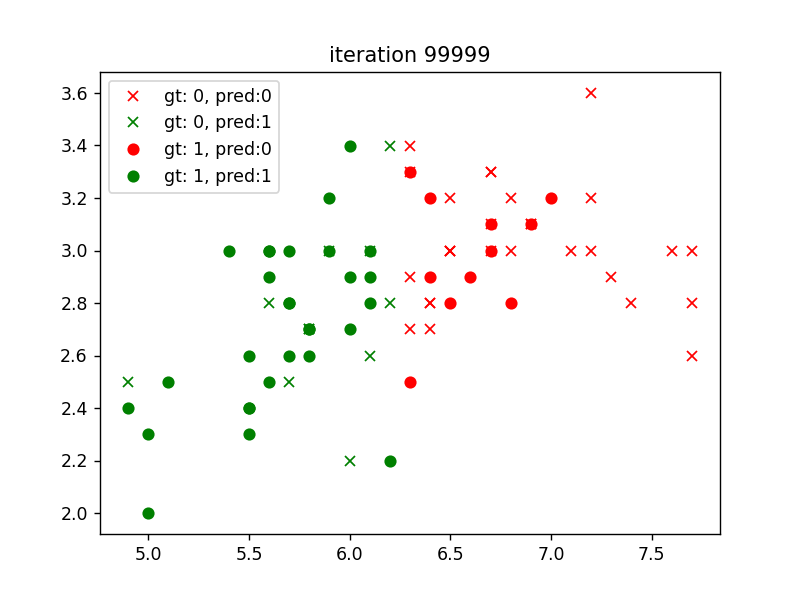

<IPython.core.display.Javascript object>


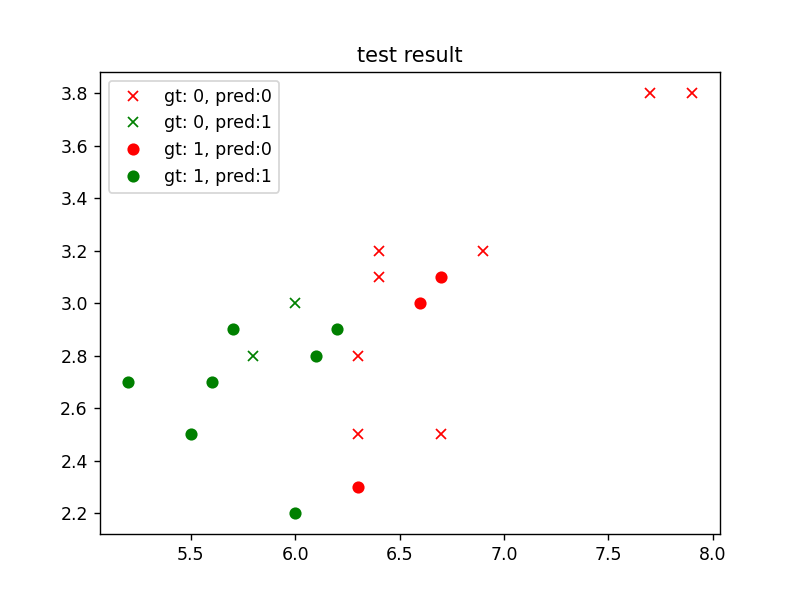

Accuracy is 0.75


In [12]:
#Train
weights = logistic_regression_train(data_train, labels_train, max_iters=100000, lr=1e-3, print_period=100, plot_period=100000)
#Predict
predictions = logistic_regression_classify(data_test, weights)
#Calculate accuracy
fig = helpers.visualize_predictions(data=data_test, labels_gt=labels_test, labels_pred=predictions)
plt.title("test result")
print("Accuracy is", accuracy(labels_test, predictions))

**Q: Comment on the accuracy. What is the difference between the dataset  in the first part and this one?**
 
The accuracy here is much lower than in the first part. This is because, for these two features, the classes *virginia* and *versicolor* are not linearly separable. In fact, these classes cannot be perfectly separated even with a non-linear boundary as some of the samples of both classes completely overlap. In the first dataset, the two classes were linearly separable.